In [1]:
import numpy as np
from qutip import *
import dask
import pandas as pd
from dask import delayed
import dask.bag as db
import dask.array as da
from dask.distributed import Client, LocalCluster,progress
# from tqdm import tqdm
import importlib
import functions_fbq
importlib.reload(functions_fbq)
from functions_fbq import *
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from figurestyle import *
figure_features()

In [2]:
cluster = LocalCluster(n_workers=20, threads_per_worker=1)
client = Client(cluster)

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:51331
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51343'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51344'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51345'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51346'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51347'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51348'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51349'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51350'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:51334'
INFO:distributed.nanny:        St

In [74]:
Ec = 40e9
El = 0.05e9
# EDelta = 20e9
eigvals = 2
phi_ext = 0

# El_list = np.logspace(np.log10(10e6), np.log10(50e9), 20)
EDelta_list = np.linspace(10e9, 40e9, 30)
r_list = np.linspace(0.01, 0.99, 20)
EDelta_r_pairs = [(EDelta,r) for EDelta in EDelta_list for r in r_list]
statistical_fidelity_matrix = np.zeros((2,len(EDelta_list), len(r_list)))
# bosonic_fidelity_matrix = np.zeros((len(EDelta_list), len(r_list)))
# disjointness_matrix = np.zeros((len(EDelta_list), len(r_list)))

In [75]:
@delayed
def statistical_fidelity_function(EDelta,r):
    _,ekets = eigensystem_fbq(Ec, El, EDelta, phi_ext, r, N = 100, eigvals = 2)
    rho_0_f = (ekets[0]*ekets[0].dag()).ptrace(0)
    rho_1_f = (ekets[1]*ekets[1].dag()).ptrace(0)

    rho_0_b = (ekets[0]*ekets[0].dag()).ptrace(1)
    rho_1_b = (ekets[1]*ekets[1].dag()).ptrace(1)
    return [1-np.abs(((rho_0_f.sqrtm()*rho_1_f*rho_0_f.sqrtm()).sqrtm()).tr())**4, 1-np.abs(((rho_0_b.sqrtm()*rho_1_b*rho_0_b.sqrtm()).sqrtm()).tr())**4]


In [76]:
# Crear un dask bag a partir de la lista de tuplas y mapear la función process_r
results_bag = db.from_sequence(EDelta_r_pairs).map(lambda x: statistical_fidelity_function(x[0], x[1]))

# Calcular los resultados
computed_results = dask.compute(*results_bag)

# Asignar los resultados a las matrices correspondientes
k = 0
for i, EDelta in enumerate(EDelta_list):
    for j, r in enumerate(r_list):
        statistical_fidelity_matrix[:,i,j] = computed_results[k]
        # fermionic_fidelity_matrix[i,j] = computed_results[1][k]
        k += 1

In [78]:
EDelta_mesh, r_mesh = np.meshgrid(EDelta_list, r_list, indexing="ij")

EDelta_flat = EDelta_mesh.flatten()
r_flat = r_mesh.flatten()
fidelity_flat = statistical_fidelity_matrix.flatten()

# data = {'El': El_flat, 'r': r_flat, 'Fidelidad': fidelity_flat}
# df = pd.DataFrame(data)

# # filename = f'fermionic_fidelity_Ec_{Ec*1e-9:.0f}_Delta_{EDelta*1e-9:.0f}_phi_ext_{phi_ext:.2f}.csv'
# df.to_csv(filename, index=False)

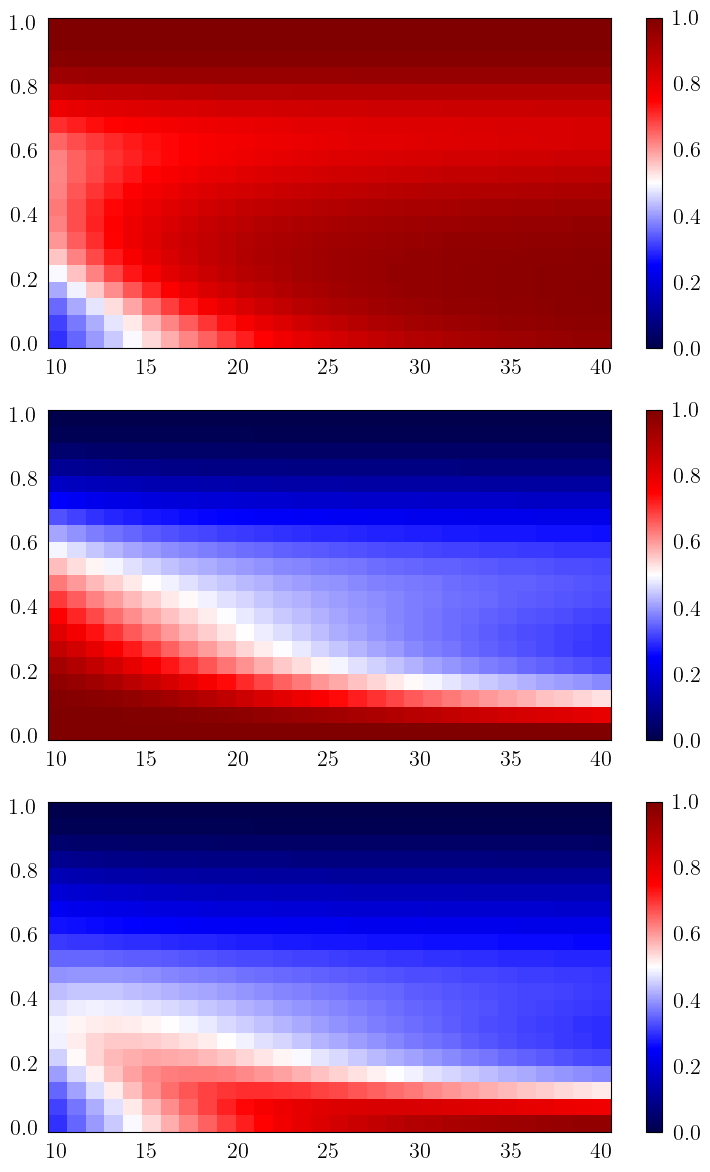

In [79]:
fig, ax = plt.subplots(3,1,figsize=(8, 12))
# plt.rcParams.update(plt.rcParamsDefault)
# plt.rcParams.update(d)
fid = ax[0].pcolormesh(EDelta_mesh*1e-9, r_mesh, statistical_fidelity_matrix[0,:,:], cmap='seismic', vmax = 1, vmin = 0)
fid = ax[1].pcolormesh(EDelta_mesh*1e-9, r_mesh, statistical_fidelity_matrix[1,:,:], cmap='seismic', vmax = 1, vmin = 0)
fid = ax[2].pcolormesh(EDelta_mesh*1e-9, r_mesh, statistical_fidelity_matrix[0,:,:]*statistical_fidelity_matrix[1,:,:], cmap='seismic', vmax = 1, vmin = 0)
# fid = ax[2].pcolormesh(EDelta_mesh*1e-9, r_mesh, bosonic_fidelity_matrix, cmap='seismic', vmax = 1, vmin = 0)
# ax[0].set_xscale('log')
# ax[1].set_xscale('log')
# ax[2].set_xscale('log')
# ax.set_xlabel(r'$E_L$ (GHz)')
# ax.set_ylabel(r'$r$')
# ax.set_title(r'Fermionic $\quad 1-\left(tr \sqrt{ \sqrt{\rho_0} \rho_1 \sqrt{\rho_0}}\right)^4 \quad E_C = $' + f'{Ec*1e-9:.0f} GHz, ' + r'$\Delta = $' + f'{EDelta*1e-9:.0f} GHz, ' + r'$\phi_{ext} = $' + f'{phi_ext:.2f}', fontsize = 14)
fig.colorbar(fid, ax=ax[1])
fig.colorbar(fid, ax=ax[0])
fig.colorbar(fid, ax=ax[2])

fig.tight_layout()
# fig.savefig(f'figures/fermionic_fidelity_Ec_{Ec*1e-9:.0f}_Delta_{EDelta*1e-9:.0f}_phi_ext_{phi_ext:.2f}.pdf')
plt.show()

## Disjointness

In [4]:
def value_to_integrate(psi_0,psi_1,phi_ket_list,theta,phi,i):
    return (np.abs((psi_0.dag()*(np.cos(theta/2)*tensor(phi_ket_list[i],basis(2,0)) + np.sin(theta/2)*np.exp(1j*phi)*tensor(phi_ket_list[i],basis(2,1))))[0,0])**2 , np.abs((psi_1.dag()*(np.cos(theta/2)*tensor(phi_ket_list[i],basis(2,0)) + np.sin(theta/2)*np.exp(1j*phi)*tensor(phi_ket_list[i],basis(2,1))))[0,0])**2)

In [5]:
@delayed
def disjointness_function(El,r):
    _,ekets = eigensystem_fbq(Ec,El,EDelta,phi_ext,r, N = 100, eigvals = 2)
    psi_0 = ekets[0]
    psi_1 = ekets[1]
    phi_ZPF=(2.0 * Ec / El) ** 0.25
    phi_op= (destroy(100).dag() + destroy(100)) * phi_ZPF
    phi_ket_list = phi_op.eigenstates()[1]

    theta_discretization = 5
    phi_discretization = 5

    A = np.zeros((100,theta_discretization,phi_discretization))
    B = np.zeros((100,theta_discretization,phi_discretization))

    for i in range(100):
        for j,theta in enumerate(np.linspace(0,np.pi,theta_discretization)):
            for k,phi in enumerate(np.linspace(0,2*np.pi,phi_discretization + 1)[:-1]):
                A[i,j,k],B[i,j,k] = value_to_integrate(psi_0,psi_1,phi_ket_list,theta,phi, i)
    return (A*B).sum()/A.sum()/B.sum()

In [6]:
# Crear un dask bag a partir de la lista de tuplas y mapear la función process_r
results_bag = db.from_sequence(El_r_pairs).map(lambda x: disjointness_function(x[0], x[1]))

# Calcular los resultados
computed_results = dask.compute(*results_bag)

# Asignar los resultados a las matrices correspondientes
k = 0
for i, El in enumerate(El_list):
    for j, r in enumerate(r_list):
        disjointness_matrix[i,j] = computed_results[k]
        k += 1